✅ XGBoost MAE: 1440.21, RMSE: 3460.02


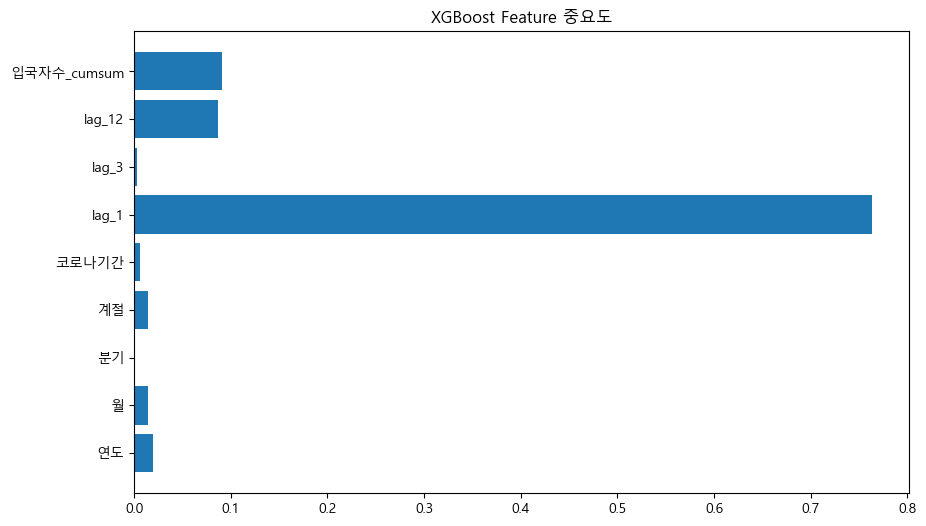

KeyError: '연월'

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ✅ 한글 폰트 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1️⃣ CSV 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv', encoding='utf-8')

# 2️⃣ 연월 컬럼 안전 필터링
if '연월' in df.columns:
    df = df[df['연월'].astype(str).str.contains('년|월|\\-')]

# 3️⃣ 사용자 입력 검증 함수
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} 입력 (없으면 Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"❌ 일치하는 {column_name} 없음. 다시 입력하세요.")

# 4️⃣ 국가 입력 (필수)
country = get_valid_input('국적')

# 5️⃣ 목적 입력 (선택)
purpose = get_valid_input('목적', allow_blank=True)

# 6️⃣ 조건 필터링
df = df[df['국적'] == country]
if purpose:
    df = df[df['목적'] == purpose]

if df.empty:
    raise ValueError("⚠️ 조건에 맞는 데이터가 없습니다. 프로그램 종료.")

# 7️⃣ Feature Engineering
df['lag_1'] = df['입국자수'].shift(1)
df['lag_3'] = df['입국자수'].shift(3)
df['lag_12'] = df['입국자수'].shift(12)
df['입국자수_cumsum'] = df['입국자수'].cumsum()
df = df.dropna()

le_season = LabelEncoder()
le_corona = LabelEncoder()

df['계절'] = le_season.fit_transform(df['계절'])
df['코로나기간'] = le_corona.fit_transform(df['코로나기간'])

# 8️⃣ Feature 선택
features = ['연도', '월', '분기', '계절', '코로나기간', 'lag_1', 'lag_3', 'lag_12', '입국자수_cumsum']
X = df[features]
y = df['입국자수']

# 9️⃣ 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 🔟 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 1️⃣1️⃣ XGBoost + GridSearchCV
params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
grid = GridSearchCV(XGBRegressor(), params, cv=2)
grid.fit(X_train, y_train)
xgb_model = grid.best_estimator_

# 1️⃣2️⃣ 예측 + 평가
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"✅ XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 1️⃣3️⃣ Feature 중요도
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_model.feature_importances_)
plt.title('XGBoost Feature 중요도')
plt.show()

# 1️⃣4️⃣ Prophet Long 변환 + 안전한 연월 변환
df['연월'] = df['연월'].astype(str).str.replace('년', '-').str.replace('월', '')
df['ds'] = pd.to_datetime(df['연월'] + '-01', errors='coerce')
df = df[df['ds'].notna()]  # NaT 제거

prophet_df = df[['ds', '입국자수']].rename(columns={'입국자수': 'y'})

m = Prophet()
m.add_country_holidays(country_name='KR')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

fig = m.plot(forecast)
plt.title('Prophet 예측 (한국 휴일 포함)')
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))


Importing plotly failed. Interactive plots will not work.


✅ XGBoost MAE: 472.47, RMSE: 562.20
      실제값          예측값       연월
0      95   472.600006  2009-11
1      73   472.600006  2009-12
2     135   381.760834  2010-01
3     391   461.398804  2010-02
4      61   536.146851  2010-03
..    ...          ...      ...
182   303   654.072266  2025-01
183  1716   606.117432  2025-02
184   272  1705.581543  2025-03
185   139   632.793091  2025-04
186   743   918.688599  2025-05

[187 rows x 3 columns]
            연월  입국자수
13960  2025-01  3818
13961  2025-02  2558
13962  2025-03  2133
13963  2025-04  4329
13964  2025-05  3326
          연월          예측값
182  2025-01   654.072266
183  2025-02   606.117432
184  2025-03  1705.581543
185  2025-04   632.793091
186  2025-05   918.688599


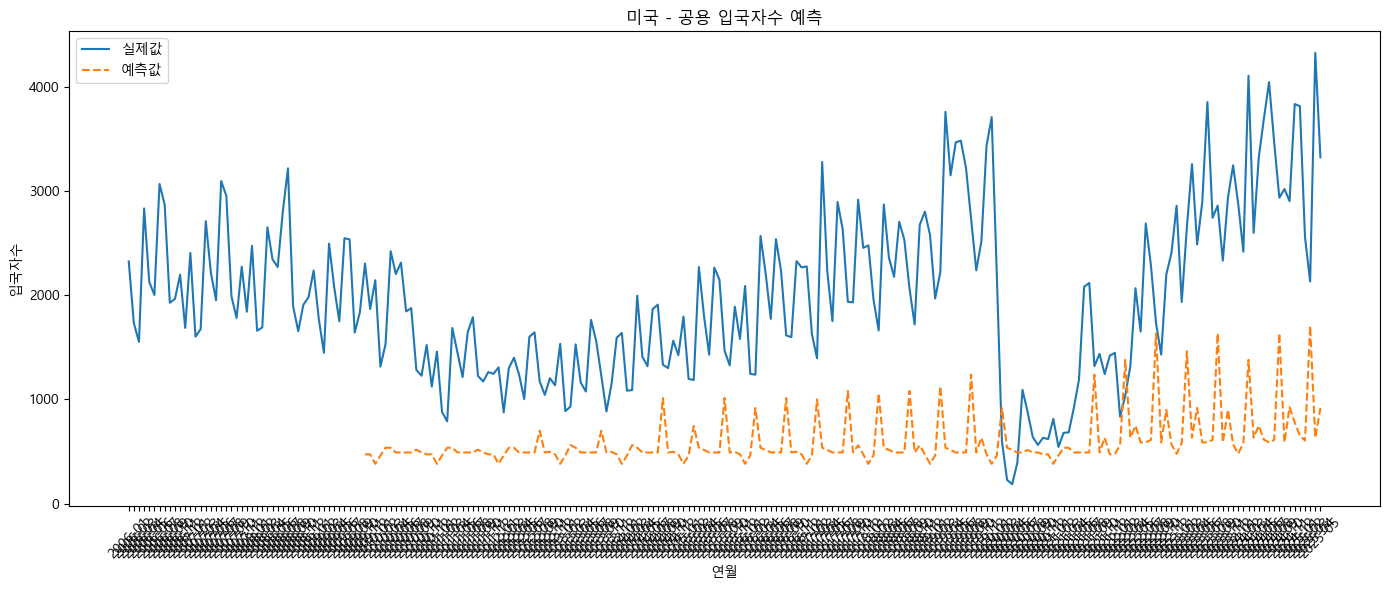

            연월    입국자수
14205  2025-01   50542
14206  2025-02   50441
14207  2025-03  108594
14208  2025-04  129889
14209  2025-05  108690
          연월          예측값
182  2025-01   654.072266
183  2025-02   606.117432
184  2025-03  1705.581543
185  2025-04   632.793091
186  2025-05   918.688599


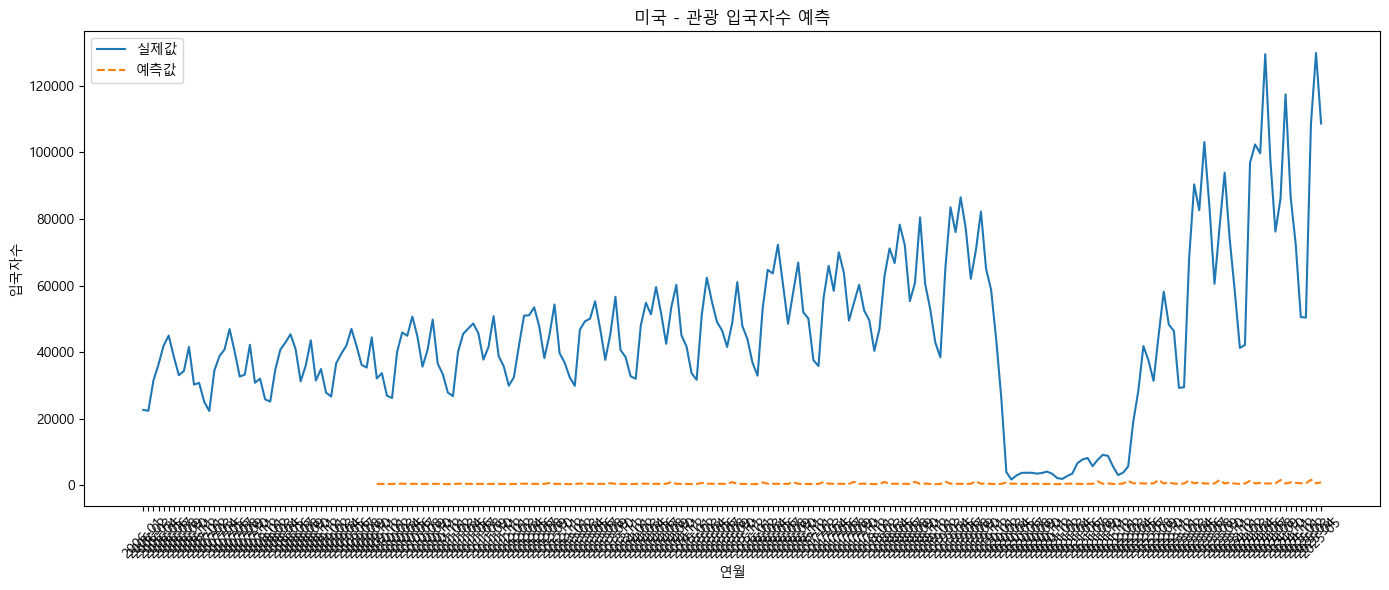

            연월  입국자수
14450  2025-01   300
14451  2025-02   261
14452  2025-03   257
14453  2025-04   244
14454  2025-05   270
          연월          예측값
182  2025-01   654.072266
183  2025-02   606.117432
184  2025-03  1705.581543
185  2025-04   632.793091
186  2025-05   918.688599


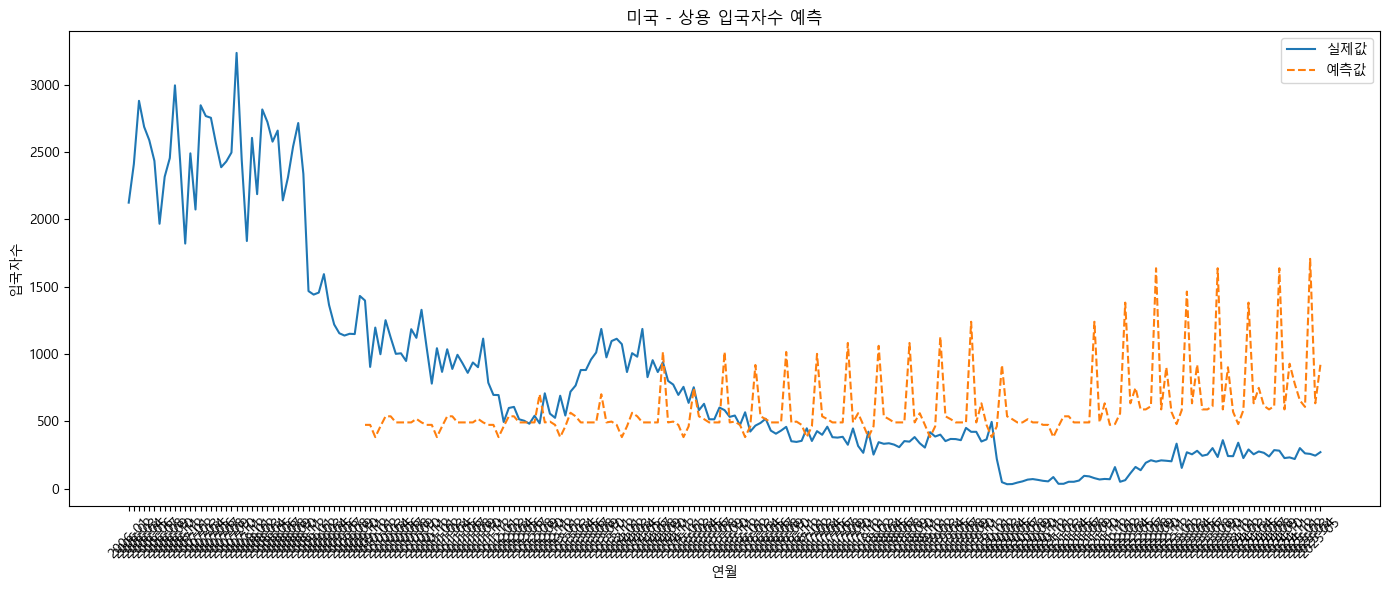

            연월  입국자수
14695  2025-01   303
14696  2025-02  1716
14697  2025-03   272
14698  2025-04   139
14699  2025-05   743
          연월          예측값
182  2025-01   654.072266
183  2025-02   606.117432
184  2025-03  1705.581543
185  2025-04   632.793091
186  2025-05   918.688599


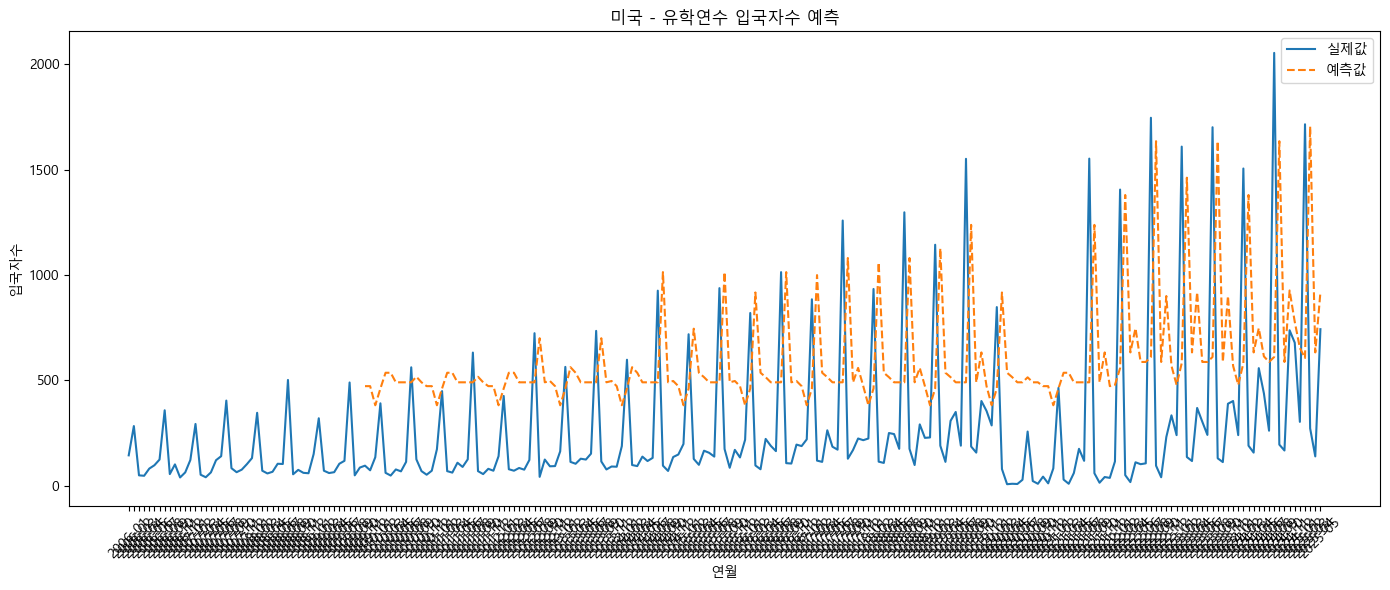

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from prophet import Prophet
import matplotlib.pyplot as plt

# ✅ 한글 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1️⃣ CSV 로드
df = pd.read_csv('../../jin/data/processed/외국인입국자_전처리완료_딥러닝용.csv', encoding='utf-8')

# 2️⃣ 사용자 입력 함수
def get_valid_input(column_name, allow_blank=False):
    unique_vals = df[column_name].unique()
    while True:
        user_input = input(f"{column_name} 입력 (없으면 Enter): ").strip().lower().replace(' ', '')
        if allow_blank and user_input == "":
            return None
        match = None
        for val in unique_vals:
            val_clean = val.strip().lower().replace(' ', '')
            if user_input == val_clean:
                match = val
                break
        if match:
            return match
        else:
            print(f"❌ 일치하는 {column_name} 없음. 다시 입력.")

# 국가 입력
country = get_valid_input('국적')
# 목적 입력
purpose = get_valid_input('목적', allow_blank=True)

# 3️⃣ 필터링
df = df[df['국적'] == country]
if purpose:
    df = df[df['목적'] == purpose]

# ✅ 필터링 예외처리
if df.empty:
    raise ValueError("⚠️ 조건에 맞는 데이터가 없습니다.")

# 4️⃣ 인코딩
le_season = LabelEncoder()
le_corona = LabelEncoder()
df['계절'] = le_season.fit_transform(df['계절'])
df['코로나기간'] = le_corona.fit_transform(df['코로나기간'])
df['연월'] = df['연도'].astype(str) + '-' + df['월'].astype(str).str.zfill(2)

# 5️⃣ 피처 엔지니어링
df['lag_1'] = df['입국자수'].shift(1)
df['lag_3'] = df['입국자수'].shift(3)
df['lag_12'] = df['입국자수'].shift(12)
df['입국자수_cumsum'] = df['입국자수'].cumsum()
df = df.dropna()

# 6️⃣ Feature 선택
features = ['연도', '월', '분기', '계절', '코로나기간', 'lag_1', 'lag_3', 'lag_12', '입국자수_cumsum']
X = df[features]
y = df['입국자수']
ym = df['연월'].reset_index(drop=True)

# 7️⃣ 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 8️⃣ 분할
X_train, X_test, y_train, y_test, ym_train, ym_test = train_test_split(
    X_scaled, y, ym, test_size=0.2, random_state=42, shuffle=False
)

# 9️⃣ XGBoost
params = {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3]}
grid = GridSearchCV(XGBRegressor(), params, cv=2)
grid.fit(X_train, y_train)
xgb_model = grid.best_estimator_

# 🔟 예측
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"✅ XGBoost MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 🔟-2 결과 테이블
results = pd.DataFrame({
    '실제값': y_test.values,
    '예측값': y_pred,
    '연월': ym_test.values
})
print(results)

# 🔟-3 선그래프
purpose_list = [purpose] if purpose else df['목적'].unique()

for p in purpose_list:
    temp = df[df['목적'] == p] if not purpose else df
    temp_sorted = temp.sort_values(['연도', '월'])
    plt.figure(figsize=(14, 6))
    print(temp_sorted[['연월', '입국자수']].tail())
    print(results[['연월', '예측값']].tail())
    plt.plot(temp_sorted['연월'], temp_sorted['입국자수'], label='실제값')
    plt.plot(results['연월'], results['예측값'], label='예측값', linestyle='--')
    plt.xticks(rotation=45)
    plt.title(f"{country} - {p if p else '전체 목적'} 입국자수 예측")
    plt.xlabel('연월')
    plt.ylabel('입국자수')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔟-4 Prophet
prophet_df = df[['연월', '입국자수']].copy()
prophet_df.rename(columns={'연월': 'ds', '입국자수': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

m = Prophet()
m.add_country_holidays(country_name='KR')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig = m.plot(forecast)
plt.title('Prophet 예측 (한국 휴일 포함)')
plt.show()
